# Example: TGV

In [29]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [44]:
def plot_u(u, title='Velocity'):
    midpoint = int(len(u)//2)
    u_norm = np.linalg.norm(u,axis=0)
    u_xy = u_norm[:,:,midpoint]
    plt.imshow(u_xy)
    plt.title(title)
    plt.show()
    return u

def plot_vort(flow, u):
    dx = flow.units.convert_length_to_pu(1.0)
    midpoint = int(len(u)//2)
    grad_u0 = np.gradient(u[0,:,midpoint], dx)
    grad_u1 = np.gradient(u[1,:,midpoint], dx)
    vorticity = (grad_u1[0] - grad_u0[1])
    plt.imshow(vorticity, cmap='Spectral')
    plt.title('Vorticity after simulation')
    plt.show()

def run(lattice, coll, res, Re, Ma):
    flow = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=Ma, lattice=lattice)
    collision = coll(lattice, tau=flow.units.relaxation_parameter_lu)
    simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=lt.StandardStreaming(lattice))
    simulation.reporters.append(lt.ObservableReporter(lt.EnergySpectrum(lattice, flow), interval=500, out=None))
    if lattice.stencil == lt.D3Q19:
        prefix = 'D3Q19_'
    elif lattice.stencil == lt.D3Q27:
        prefix = 'D3Q27_'
    else:
        return
    if coll == lt.BGKCollision:
        prefix += 'BGK_'
    elif coll == lt.KBCCollision3D:
        prefix += 'KBC_'
    else:
        return
    prefix += '_res' + str(res) + '_Re' + str(Re) + '_Ma' + str(Ma)
    simulation.reporters.append(lt.ObservableReporter(lt.Enstrophy(lattice, flow), interval=500, out=open('data/'+prefix+'_enstrophy', 'w')))
    simulation.reporters.append(lt.ObservableReporter(lt.EnergySpectrum(lattice, flow), interval=500, out=open('data/'+prefix+'_energy_spectrum', 'w')))
    simulation.reporters.append(lt.ObservableReporter(lt.IncompressibleKineticEnergy(lattice, flow), interval=500, out=open('data/'+prefix+'_energy_incompressible', 'w')))

    u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f)).cpu().numpy()
    plot_u(u, 'Initialized velocity')

    simulation.initialize_pressure()
    simulation.initialize_f_neq()
    mlups = simulation.step(num_steps=15000)
    print("Performance in MLUPS:", mlups)

    u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f)).cpu().numpy()
    plot_u(u, 'Velocity after simulation')
    plot_vort(flow, u)

steps     time     EnergySpectrum
steps     time     Enstrophy
steps     time     EnergySpectrum
steps     time     IncompressibleKineticEnergy


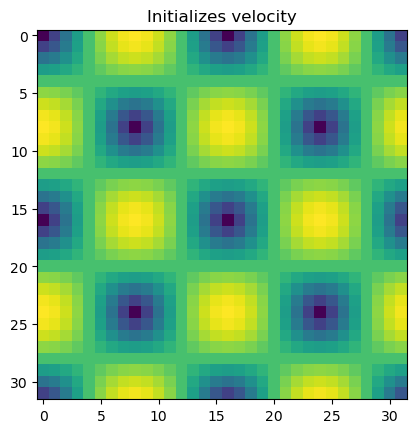

Performance in MLUPS: 33.70780682963349


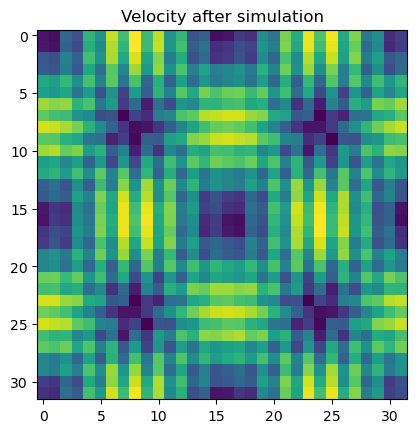

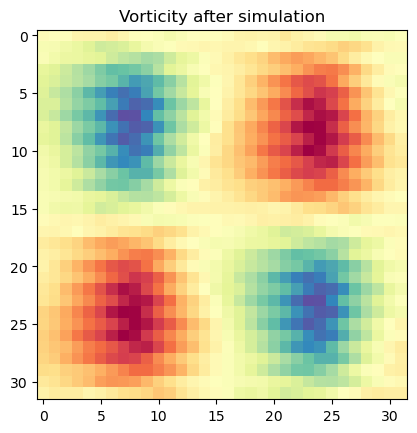

In [45]:
lattice = lt.Lattice(lt.D3Q19, device = "cuda:0", use_native=False)
run(lattice, lt.BGKCollision, 32, 10, 0.01)

In [47]:
for stencil in [lt.D3Q27, lt.D3Q19]:
    lattice = lt.Lattice(stencil, device = "cuda:0", use_native=False)
    for coll in [lt.BGKCollision, lt.KBCCollision3D]:
        for res in [64, 75, 128, 256, 512]:
            for Re in [10, 100, 1e4, 1e5, 1e6]:
                for Ma in [0.1, 0.05, 0.01]:
                    print('Current simulation running since ', datetime.datetime.now())
                    run(lattice, coll, res, Re, Ma)

NameError: name 'datetime' is not defined